In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [3]:
DATASET_PATH = "C:/Users/suchi/Desktop/Opencv-projct/dataset/"


In [4]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)


In [6]:
def load_and_extract_features(dataset_path):
    images = []
    image_paths = []
    feature_vectors = []

    for img_file in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, img_file)
        
        if os.path.isfile(img_path):  
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  
            img = preprocess_input(img)  
            
            images.append(img)
            image_paths.append(img_path)

    images = np.array(images, dtype=np.float32)  

    
    feature_vectors = feature_extractor.predict(images)
    
    return feature_vectors, image_paths


In [7]:

feature_vectors, image_paths = load_and_extract_features(DATASET_PATH)

24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step 


In [8]:
# Save extracted features for later use
np.save("features.npy", feature_vectors)
np.save("image_paths.npy", image_paths)

In [9]:
print(f"Extracted features for {len(feature_vectors)} images. Feature shape: {len(image_paths)}")

Extracted features for 743 images. Feature shape: 743


# Clustering

In [10]:
features = np.load("features.npy") 
image_paths = np.load("image_paths.npy")


In [11]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [12]:
dbscan = DBSCAN(eps=10., min_samples=1, metric='euclidean')  
labels = dbscan.fit_predict(features_scaled)

In [13]:
np.save("cluster_labels.npy", labels)

In [14]:
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN found {num_clusters} clusters (people)")

DBSCAN found 743 clusters (people)


# Feature extraction for search

In [15]:
from transformers import ViTFeatureExtractor, ViTModel
import torch

# Load Pretrained ViT
device = "cuda" if torch.cuda.is_available() else "cpu"
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
model.eval()

# Extract Features Using ViT
def extract_vit_feature(img_path):
    from PIL import Image
    img = Image.open(img_path).convert("RGB")
    inputs = feature_extractor(img, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        feature = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

    return feature

C:\Users\suchi\Desktop\tango\envs\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Load Dataset & Extract Features
image_folder = "C:/Users/suchi/Desktop/Opencv-projct/dataset"
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
features = np.array([extract_vit_feature(img) for img in image_paths])

# Save Features & Paths for Future Retrieval
np.save("features.npy", features)
np.save("image_paths.npy", np.array(image_paths))

print("Saved")

# Query Image Search

In [18]:
import faiss

d = features.shape[1]  
index = faiss.IndexFlatL2(d)  
index.add(features)  

faiss.write_index(index, "faiss_index.bin")

def search_faiss(query_feature, top_k=5):
    query_feature = np.array(query_feature).reshape(1, -1).astype("float32")
    distances, indices = index.search(query_feature, top_k)

     
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_img_path), cv2.COLOR_BGR2RGB))
    plt.title("Query Image")
    plt.axis("off")

    
    for i, idx in enumerate(indices[0]):
        print(f"Match {i+1}: {image_paths[idx]} (Distance: {distances[0][i]})")
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Match {i+1}")
        plt.axis("off")
    
    plt.show()
    return indices[0]

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [20]:
features = np.load("features.npy")
image_paths = np.load("image_paths.npy")

Match 1: C:/Users/suchi/Desktop/Opencv-projct/dataset\0001_c1s1_001051_00.jpg (Distance: 0.0)
Match 2: C:/Users/suchi/Desktop/Opencv-projct/dataset\0001_c5s1_014501_00.jpg (Distance: 6.061498165130615)
Match 3: C:/Users/suchi/Desktop/Opencv-projct/dataset\0001_c2s1_000351_00.jpg (Distance: 10.383035659790039)
Match 4: C:/Users/suchi/Desktop/Opencv-projct/dataset\0001_c3s2_118119_00.jpg (Distance: 10.809076309204102)
Match 5: C:/Users/suchi/Desktop/Opencv-projct/dataset\0001_c6s1_009676_00.jpg (Distance: 11.490660667419434)


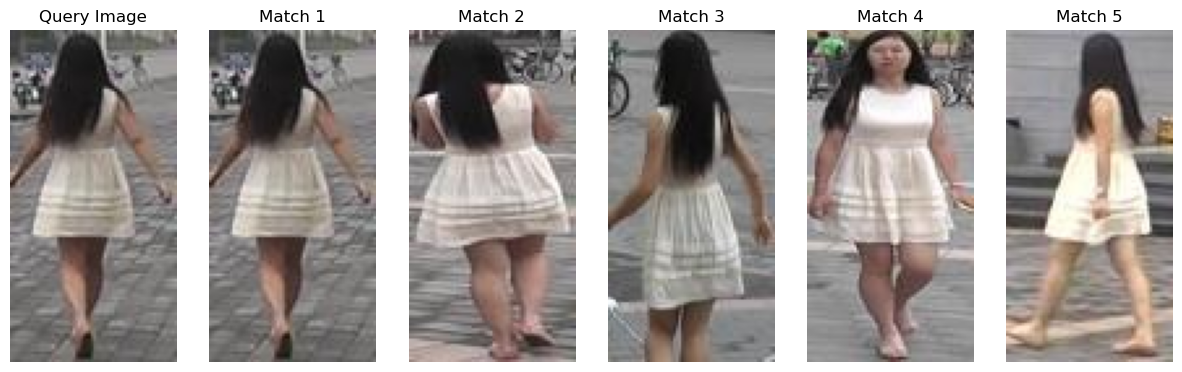

array([ 0, 26,  8, 16, 47])

In [22]:
query_img_path = "C:/Users/suchi/Desktop/Opencv-projct/dataset/0001_c1s1_001051_00.jpg"
query_feature = extract_vit_feature(query_img_path)
search_faiss(query_feature, top_k=5)

#  Add Attribute Extraction

In [26]:
import cv2
import numpy as np
import webcolors
from collections import Counter

In [28]:
def closest_color(rgb_tuple):
        min_dist = float("inf")
        closest_name = None
        for color in webcolors.names("css3"):
            hex_code = webcolors.name_to_hex(color)
            r, g, b = webcolors.hex_to_rgb(hex_code)
            dist = sum((component1 - component2) ** 2 for component1, component2 in zip((r, g, b), rgb_tuple))
            if dist < min_dist:
                min_dist = dist
                closest_name = color
        return closest_name

In [29]:
def get_dominant_color(image_path, k=3):
    """Extract dominant clothing color and return a readable name."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))  # Flatten image to (num_pixels, 3)
    
    kmeans = cv2.kmeans(
        np.float32(img), k, None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
        10, cv2.KMEANS_RANDOM_CENTERS
    )[2]

    color_counts = Counter(tuple(color) for color in np.uint8(kmeans))
    dominant_rgb = max(color_counts, key=color_counts.get)  # Most common color
    color_name = closest_color(dominant_rgb)

    return color_name


In [30]:

query_image = "C:/Users/suchi/Desktop/Opencv-projct/dataset/0001_c1s1_001051_00.jpg"
dominant_color = get_dominant_color(query_image)
print(f" Detected Clothing Color: {dominant_color}")

👕 Detected Clothing Color: forestgreen


C:\Users\suchi\AppData\Local\Temp\ipykernel_8112\1910124893.py:7: RuntimeWarning: overflow encountered in scalar add
  dist = sum((component1 - component2) ** 2 for component1, component2 in zip((r, g, b), rgb_tuple))
C:\Users\suchi\AppData\Local\Temp\ipykernel_8112\1910124893.py:7: RuntimeWarning: overflow encountered in scalar subtract
  dist = sum((component1 - component2) ** 2 for component1, component2 in zip((r, g, b), rgb_tuple))


# 2D visualization

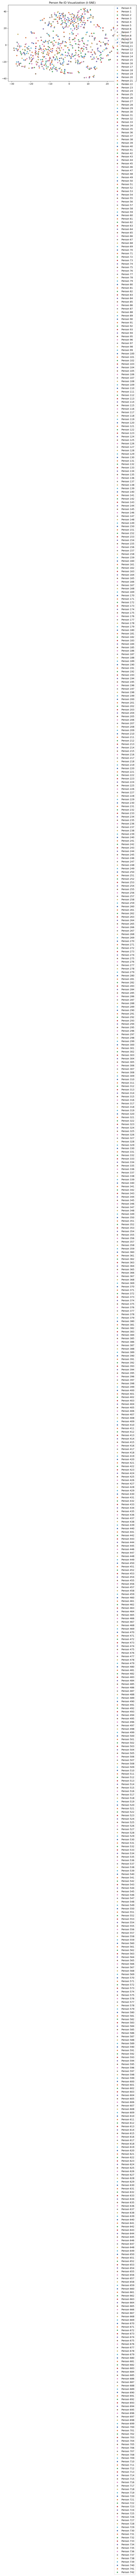

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce feature dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=[f"Person {i}" for i in range(len(features))], palette="deep")
plt.title("Person Re-ID Visualization (t-SNE)")
plt.show()
